In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Importando dados de teste e treinamento

test = pd.read_csv(r"C:\Users\laila\Documents\regressor-oncase\regression_test.csv")
train = pd.read_csv(r"C:\Users\laila\Documents\regressor-oncase\regression_train.csv")

train.describe()

,target,X1,X2,X3,X4,X5,X6,X7
count,715.000000,1042.000000,1031.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,1349.940229,2.421925,-0.460781,52.094329,2.462871,-65.284233,4.381958,-1.287435
std,1593.201095,3.182976,4.426286,31.374828,2.541632,9.033489,3.290306,11.066380
min,0.062551,-8.699406,-13.651540,38.035456,0.002360,-121.450423,0.000000,-69.835905
25%,230.632308,0.170590,-3.307931,47.087106,0.671196,-69.126630,0.000000,-7.830007
50%,808.374368,2.508671,-0.461150,49.972867,1.652609,-65.360660,5.000000,-1.074191
75%,1849.754221,4.540218,2.406651,52.674305,3.361181,-61.187635,8.000000,5.659476
max,10382.469480,12.380693,12.926106,500.000000,18.813009,53.919202,8.000000,30.376348


In [3]:
# Data filtering: Droping rows with NaN values on both datasets

train = train.dropna()
test = test.dropna()

In [4]:
# Selecionando as entradas e o target dos dados

X_train = train.drop(columns=["target"])
Y_train = train["target"]

X_test = test.drop(columns=["target"])
Y_test = test["target"]

# Craindo lista dos nomes dos atributos nos datasets

feat_train = list(X_train.columns)
feat_test = list(X_test.columns)

In [5]:
train.corr(method='pearson')

,target,X1,X2,X3,X4,X5,X6,X7
target,1.000000,0.514485,0.938318,0.057441,-0.011001,-0.023407,0.040508,0.938318
X1,0.514485,1.000000,0.391877,-0.043520,0.004531,0.009388,0.034558,0.391877
X2,0.938318,0.391877,1.000000,0.030203,0.091770,-0.055510,0.045088,1.000000
X3,0.057441,-0.043520,0.030203,1.000000,0.095165,0.010467,-0.004720,0.030203
X4,-0.011001,0.004531,0.091770,0.095165,1.000000,-0.057918,-0.021941,0.091770
X5,-0.023407,0.009388,-0.055510,0.010467,-0.057918,1.000000,-0.050802,-0.055510
X6,0.040508,0.034558,0.045088,-0.004720,-0.021941,-0.050802,1.000000,0.045088
X7,0.938318,0.391877,1.000000,0.030203,0.091770,-0.055510,0.045088,1.000000


**Nota**: A maior correlação é entre os atributos X2 e X7 com o target de aproximadamente 0,94. Abaixo são traçados scatter plots entre esses atributos com o target para uma melhor visualização dessa correlação.

Text(0.5, 1.0, 'x7 x target')

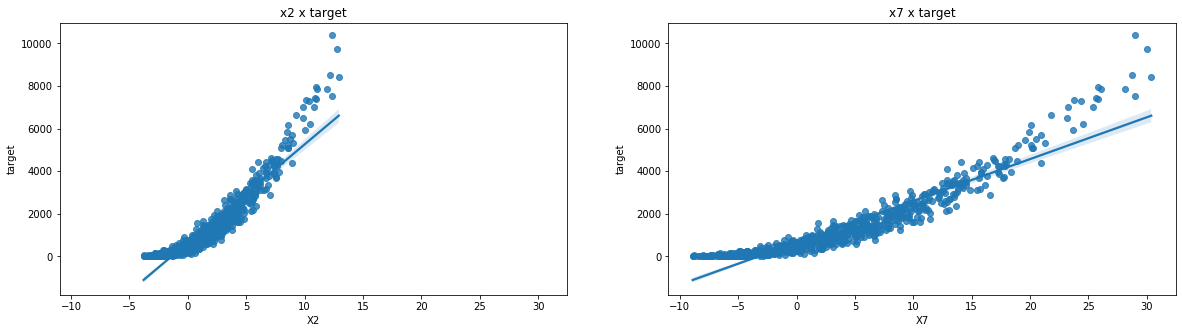

In [6]:
# Gráficos de dispersão x2, x7 x target (dataset de treinamento)

f, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
sns.regplot(x="X2", y="target", data=train, ax=axes[0]).set_title("x2 x target")
sns.regplot(x="X7", y="target", data=train, ax=axes[1]).set_title("x7 x target")

In [7]:
# Normalização dos dados e treinamento dos modelos

def normalize(X):
    X_norm = X.copy(deep=True)
    numerical_cols = X_norm.columns[X_norm.dtypes == 'float'].tolist()
    X_norm[numerical_cols] = (X_norm[numerical_cols] - X_norm[numerical_cols].min()) / (X_norm[numerical_cols].max() - X_norm[numerical_cols].min())
    return X_norm

def train_models(models, X_train, Y_train, X_test, Y_test, k=30):
    metrics = {}
    X_norm = normalize(X_train)
    X_test_norm = normalize(X_test)    
    kf = KFold(n_splits=k, shuffle=True)
    X_norm = X_norm.values
    y = Y_train.values
    for model in models:
        clf = models[model]
        metrics[model] = {'train': [], 'valid':[], 'test': []}
        for train_index, valid_index in kf.split(X_train):
            X_train, X_valid = X_norm[train_index], X_norm[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
            clf.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train)
            y_pred_valid = clf.predict(X_valid)
            y_pred_test = clf.predict(X_test_norm)
            metrics[model]['train'].append(mean_squared_error(y_train, y_pred_train))
            metrics[model]['valid'].append(mean_squared_error(y_valid, y_pred_valid))
            metrics[model]['test'].append(mean_squared_error(Y_test, y_pred_test))
        
        print(model)
        mean_train_rmse = np.round(np.array(metrics[model]['train']).mean(), 3)
        mean_train_rmse_std = np.round(np.array(metrics[model]['train']).std() * 2, 3)
        print(f'Train\t\t RMSE: {mean_train_rmse} (+/- {mean_train_rmse_std})')
        mean_valid_rmse = np.round(np.array(metrics[model]['valid']).mean(), 3)
        mean_valid_rmse_std = np.round(np.array(metrics[model]['valid']).std() * 2, 3)
        print(f'Validation\t RMSE: {mean_valid_rmse} (+/- {mean_valid_rmse_std})')
        mean_test_rmse = np.round(np.array(metrics[model]['test']).mean(), 3)
        mean_test_rmse_std = np.round(np.array(metrics[model]['test']).std() * 2, 3)
        print(f'Test\t\t RMSE: {mean_test_rmse} (+/- {mean_test_rmse_std})')
        print(f'\nRegression Report (Last Fold):\n')
        print(f'RMSE: {mean_test_rmse}')
        print(f'\nR2-score: {round(r2_score(Y_test, y_pred_test), 3)}')
        print(f'\nCorrelation: {np.round(np.corrcoef(Y_test, y_pred_test), decimals=3)[0][1]}')
        print('-'*40)
            
    return metrics

In [8]:
# Modelos de treinamento a serem testados

models = {
    'Linear_Regression': LinearRegression(),
    'Decision_Tree': DecisionTreeRegressor(),
    'Random_Forest': RandomForestRegressor(),
    'Gradient_Boosting': GradientBoostingRegressor(),
    'Gaussian_Process_Regression': GaussianProcessRegressor(),
    'Support_Vector_Machine': SVR(),
    'K-Nearest_Neighbors': KNeighborsRegressor()
}

metrics = train_models(models, X_train, Y_train, X_test, Y_test)

Linear_Regression
Train		 RMSE: 210337.227 (+/- 10834.978)
Validation	 RMSE: 218698.633 (+/- 325052.661)
Test		 RMSE: 403287.797 (+/- 28809.72)

Regression Report (Last Fold):

RMSE: 403287.797

R2-score: 0.768

Correlation: 0.952
----------------------------------------
Decision_Tree
Train		 RMSE: 0.0 (+/- 0.0)
Validation	 RMSE: 78519.053 (+/- 173747.735)
Test		 RMSE: 196053.106 (+/- 38238.53)

Regression Report (Last Fold):

RMSE: 196053.106

R2-score: 0.889

Correlation: 0.98
----------------------------------------
Random_Forest
Train		 RMSE: 5859.333 (+/- 1002.783)
Validation	 RMSE: 41436.067 (+/- 102260.575)
Test		 RMSE: 130503.328 (+/- 8150.131)

Regression Report (Last Fold):

RMSE: 130503.328

R2-score: 0.92

Correlation: 0.992
----------------------------------------
Gradient_Boosting
Train		 RMSE: 1629.067 (+/- 156.698)
Validation	 RMSE: 24138.365 (+/- 69935.527)
Test		 RMSE: 119850.348 (+/- 12599.363)

Regression Report (Last Fold):

RMSE: 119850.348

R2-score: 0.928

Corre

# Análise final

O modelo que apresentou os melhores resultados tornando-se o mais adequado para o problema é o Gaussian Process Regression por apresentar o menor RMSE, o R2-score mais próximo de 1 e a melhor correlação entre o target observado e o predito de quase 100%. 